# 02 - MGWR model
This notebook contains the building, training, testing, and validation of a Multiscale Geographically Weighted Regression model te generalise the sound measurements.

In [3]:
# default libs
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# vector geo data libs
import pandas as pd
import geopandas as gpd
import contextily as cx
# raster geo data libs
import rioxarray as rxr
# audio libs
import soundfile as sf
import waveform_analysis
# OLS
from sklearn import linear_model
import statsmodels.formula.api as smf

import mgwr

# script file, not a module 
import utils

## attempt N at kriging

In [68]:
gdf = gpd.read_file('..\\output\\distributed_data.GEOJSON', engine='pyogrio', use_arrow=True)

In [69]:
gdf = gdf.clip((136783.0826,451879.0786,138490.1231,453599.2073))

from sklearn.model_selection import train_test_split
gdf_train, gdf_test = train_test_split(gdf.dropna(), test_size=0.2)
gdf_val = gdf[gdf['median_dBA_reg_adj'].isna()]

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(gdf_train[['x','y']], gdf_train['median_dBA_reg_adj'])
print(gaussian_process.kernel_)

y_test = gaussian_process.predict(gdf_test[['x','y']])
score = gaussian_process.score(gdf_test[['x','y']], gdf_test['median_dBA_reg_adj'])
print(score)

y_val = gaussian_process.predict(gdf_val[['x','y']])

gdf_train['pred'] = gdf_train['median_dBA_reg_adj']
gdf_test['pred'] = y_test
gdf_val['pred'] = y_val

gdf_pred = pd.concat([gdf_train, gdf_test, gdf_val])


68.3**2 * RBF(length_scale=0.104)
-205.84325329154962


c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

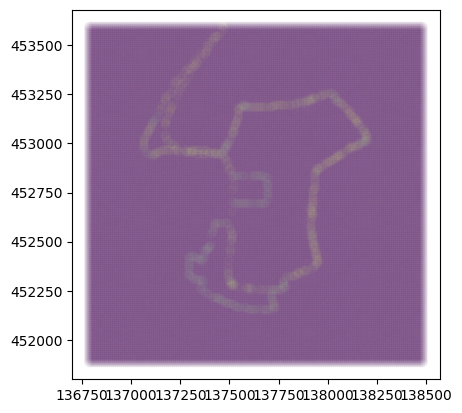

In [73]:
gdf_pred.plot(column='pred', alpha=0.04)

In [72]:
gdf_pred

,y,x,dBA_rivm,median_speed,median_dBA_raw,median_dBA_reg_adj,geometry,pred
1127887,452975.0,138115.0,63,32.071787,88.611369,71.642843,POINT (138115.000 452975.000),71.642843
1222096,452255.0,137725.0,63,33.156332,82.988698,64.130747,POINT (137725.000 452255.000),64.130747
1146153,452835.0,137515.0,68,4.944828,66.257594,63.634996,POINT (137515.000 452835.000),63.634996
1215511,452305.0,137325.0,52,11.871357,65.968026,59.671790,POINT (137325.000 452305.000),59.671790
1101705,453175.0,138095.0,66,33.548436,89.905833,72.450288,POINT (138095.000 453175.000),72.450288
...,...,...,...,...,...,...,...,...
1047987,453585.0,137605.0,61,NaN,NaN,NaN,POINT (137605.000 453585.000),0.000000
1046680,453595.0,137625.0,61,NaN,NaN,NaN,POINT (137625.000 453595.000),0.000000
1046678,453595.0,137605.0,62,NaN,NaN,NaN,POINT (137605.000 453595.000),0.000000
1046679,453595.0,137615.0,61,NaN,NaN,NaN,POINT (137615.000 453595.000),0.000000


In [5]:
gdf

,y,x,dBA_rivm,median_speed,median_dBA_raw,median_dBA_reg_adj,geometry
0,461585.0,129735.0,50,NaN,NaN,NaN,POINT (129735.000 461585.000)
1,461585.0,129745.0,50,NaN,NaN,NaN,POINT (129745.000 461585.000)
2,461585.0,129755.0,51,NaN,NaN,NaN,POINT (129755.000 461585.000)
3,461585.0,129765.0,51,NaN,NaN,NaN,POINT (129765.000 461585.000)
4,461585.0,129775.0,51,NaN,NaN,NaN,POINT (129775.000 461585.000)
...,...,...,...,...,...,...,...
1502727,450115.0,142775.0,59,NaN,NaN,NaN,POINT (142775.000 450115.000)
1502728,450115.0,142785.0,62,NaN,NaN,NaN,POINT (142785.000 450115.000)
1502729,450115.0,142795.0,66,NaN,NaN,NaN,POINT (142795.000 450115.000)
1502730,450115.0,142805.0,66,NaN,NaN,NaN,POINT (142805.000 450115.000)


In [6]:
gdf_100 = gpd.read_file('cbs_vk100_2021_v2.gpkg', engine='pyogrio', use_arrow=True)

In [10]:
gdf_100[['aantal_woningen', 'geometry']]

,aantal_woningen,geometry
0,-99997,"MULTIPOLYGON (((205400.000 611500.000, 205500...."
1,-99997,"MULTIPOLYGON (((206900.000 611000.000, 207000...."
2,5,"MULTIPOLYGON (((206300.000 610900.000, 206400...."
3,-99997,"MULTIPOLYGON (((206500.000 610900.000, 206600...."
4,-99997,"MULTIPOLYGON (((206600.000 610900.000, 206700...."
...,...,...
386019,-99997,"MULTIPOLYGON (((198300.000 307900.000, 198400...."
386020,5,"MULTIPOLYGON (((198400.000 307900.000, 198500...."
386021,5,"MULTIPOLYGON (((198300.000 307800.000, 198400...."
386022,-99997,"MULTIPOLYGON (((198400.000 307800.000, 198500...."


In [33]:
gdf_observed = gdf.dropna()
# coords - (x,y) tuple for each observation
coords = np.array([(r['x'], r['y']) for _, r in gdf_observed.iterrows()])
y = np.array(gdf_observed['median_dBA_reg_adj'])
X = np.array([[x] for x in gdf_observed['median_speed']])

In [40]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(coords, y)
gaussian_process.kernel_

43.2**2 * RBF(length_scale=15.6)

In [41]:
X_test = np.array([(r['x'], r['y']) for _, r in gdf[gdf['median_dBA_raw'].isna()].iterrows()])
y_out = gaussian_process.predict(X_test)

In [44]:
X

array([[17.50155894],
       [19.77773235],
       [18.80964127],
       ...,
       [14.84742811],
       [13.22396778],
       [15.86230956]])

In [62]:
xs.squeeze()

array([136825., 136835., 136815., ..., 137705., 137715., 137725.])

In [52]:
X_full = np.vstack((X_test, coords))
y_full = np.hstack((y_out, y))

In [66]:
y

array([61.66929616, 61.1240365 , 66.65804962, ..., 61.9351854 ,
       62.35251134, 60.96134998])

In [63]:
from shapely import Point
xs, ys= np.hsplit(X_full, 2)
test_gdf = pd.DataFrame(data={'x':xs.squeeze(), 'y':ys.squeeze(), 'v':y_full})
geometry = [Point(xy) for xy in zip(test_gdf.x, test_gdf.y)]
test_gdf = gpd.GeoDataFrame(test_gdf, crs=gdf.crs, geometry=geometry)

<Axes: >

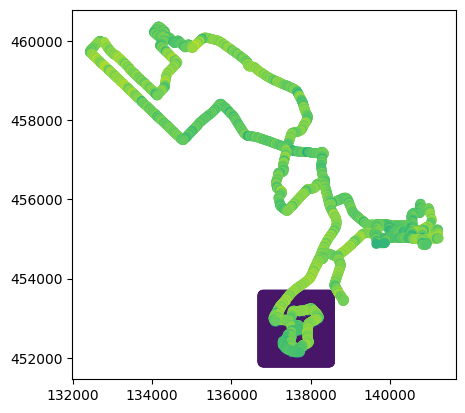

In [64]:
test_gdf.plot(column='v')

In [58]:
xs

array([[136825.],
       [136835.],
       [136815.],
       ...,
       [137705.],
       [137715.],
       [137725.]])

In [35]:
results = model.fit()

IndexError: invalid index to scalar variable.

In [34]:
X

array([[17.50155894],
       [19.77773235],
       [18.80964127],
       ...,
       [14.84742811],
       [13.22396778],
       [15.86230956]])

In [14]:
for r in gdf_observed.iterrows():
    print(r['y'])
    break

TypeError: tuple indices must be integers or slices, not str